In [8]:
import numpy as np
from graphviz import Digraph
from cov_selection.common import S, ncd_blocks, cov_to_corr
from cov_selection.Graph import Graph, RandomGraph
from cov_selection.ncd import NCD, ncd_measure, NCD_epsilon
from cov_selection.ips import IPS, ips_measure, IPS_epsilon
import time

from matplotlib import pyplot as plt
import networkx as nx

In [9]:
seed = 0
np.random.seed(seed)

In [10]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [11]:
def max_column_sum_norm(A):
        return np.max(np.sum(abs(A), axis=-1), axis=-1)

def max_deviation_norm(A):
        return np.max(abs(A))

# IPS

In [12]:
def IPS_measured(s, G, n):
    K = np.eye(s.shape[0])
    sigma = np.linalg.inv(K)
    error = []
    # it can take a long time to converge
    for _ in range(n):
        for c in G.edges:
            a = np.setdiff1d(np.arange(s.shape[0]), c)
            cc = np.ix_(c,c)
            ac = np.ix_(a,c)
            ca = np.ix_(c,a)
            aa = np.ix_(a,a)
            # update K
            L = K[cc] - np.linalg.inv(sigma[cc])
            K[cc] = np.linalg.inv(s[cc]) + L

            # update sigma
            sig_ac = sigma[ac]
            sig_ca = sigma[ca]
            sigma_cc_inv = np.linalg.inv(sigma[cc])
            sigma[ca] = np.matmul(s[cc],  np.matmul(sigma_cc_inv, sig_ca))
            sigma[ac] = np.matmul(sigma[ac], np.matmul(sigma_cc_inv, s[cc]))
            H = sigma_cc_inv -  np.matmul(sigma_cc_inv, np.matmul(s[cc], sigma_cc_inv))
            sigma[aa] = sigma[aa]-np.matmul(sig_ac, np.matmul(H, sig_ca))
            sigma[cc] = s[cc]
        error.append(ips_measure(sigma, s, G))
    return (sigma, K, error)

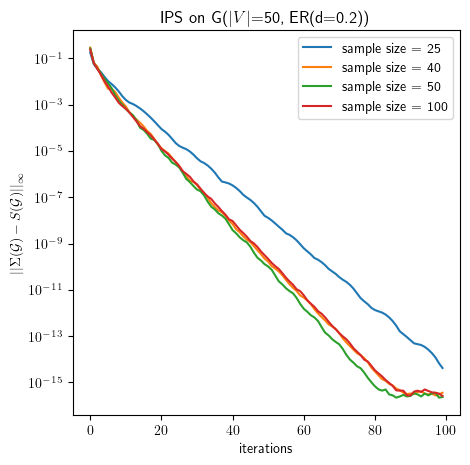

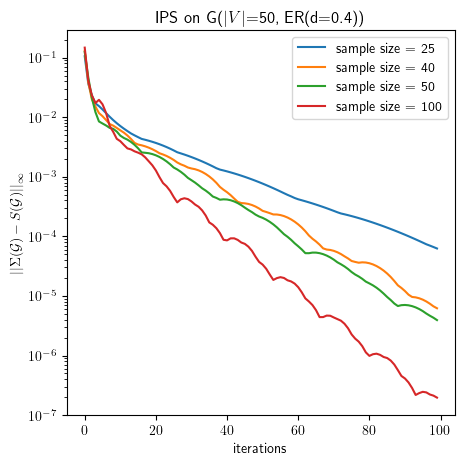

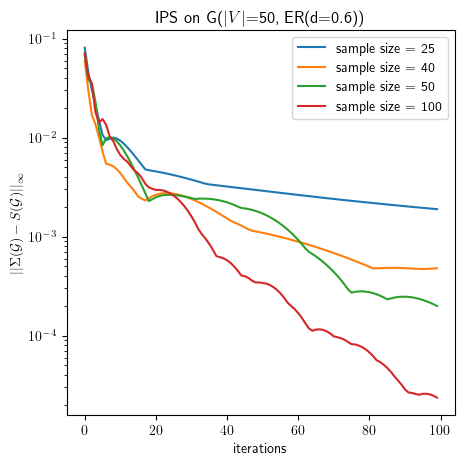

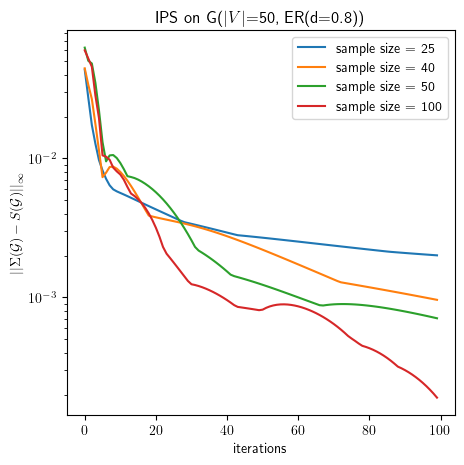

In [13]:
graphs = [
    RandomGraph(n=50, graph_structure='erdos_renyi', pd_selection='laplacian', d=0.2, seed=seed),
    RandomGraph(n=50, graph_structure='erdos_renyi', pd_selection='laplacian', d=0.4, seed=seed),
    RandomGraph(n=50, graph_structure='erdos_renyi', pd_selection='laplacian', d=0.6, seed=seed),
    RandomGraph(n=50, graph_structure='erdos_renyi', pd_selection='laplacian', d=0.8, seed=seed),
]
for G in graphs: 
    fig, ax = plt.subplots(figsize = (5,5))
    plt.rcParams['text.usetex'] = True
    iterations = 100
    sample_sizes = [25, 40, 50, 100]
    for sample_size in sample_sizes:
        s = np.cov(G.sample(sample_size), rowvar=False, bias=False)
        start = time.time()
        sigma, K, errors = IPS_measured(s, G, iterations)
        ax.plot(np.arange(iterations), errors, label=f"sample size = {sample_size}")
    ax.set_xlabel("iterations")
    ax.set_ylabel(r"$||\Sigma(\mathcal{G}) - S(\mathcal{G})||_{\infty}$")
    ax.set_yscale("log")
    ax.set_title(f"IPS on {G}")
    ax.legend()
    #plt.savefig(f"plots/ips_on_{G.n}_{int(G.d*10)}.png")

Timing: time until a certain threshhold is crossed at different sample sizes and densities

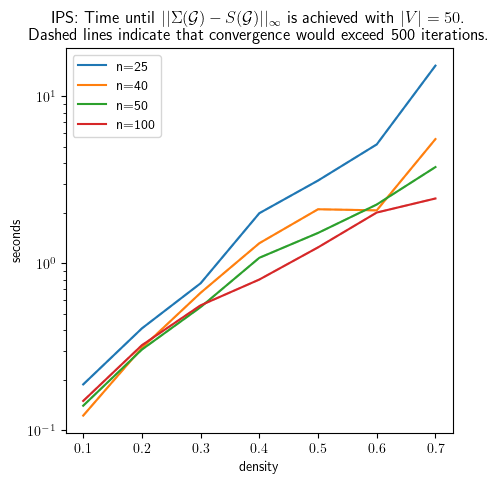

In [14]:
fig, ax = plt.subplots(figsize = (5,5))
plt.rcParams['text.usetex'] = True

n = 50
max_iter = 500
sample_sizes = [25, 40, 50, 100]
densities = np.array([0.1,0.2, 0.3,0.4, 0.5,0.6, 0.7])
epsilon = 0.001
for sample_size in sample_sizes:
    tmp = []
    tmp_i = []
    for d in densities:
        G = RandomGraph(n=n, graph_structure='erdos_renyi', pd_selection='laplacian', d=d, seed=0)
        s = np.cov(G.sample(sample_size), rowvar=False, bias=False)
        start = time.time()
        _, i = IPS_epsilon(s, G, epsilon, max_iter)
        tmp.append(time.time() - start)
        tmp_i.append(i)
    tmp_i = np.array(tmp_i)
    # Find the index of the first True value
    mask = tmp_i == max_iter
    first_true_index = np.argmax(mask)
    # If there is at least one True value, update it to False
    if mask[first_true_index]:
        mask[first_true_index] = False
    line = ax.plot(densities, tmp, ls='--', alpha=0.4)[0]
    tmp = np.array(tmp)
    ax.plot(densities[~mask], tmp[~mask], label=f"n={sample_size}", color=line.get_color())
ax.set_xlabel("density")
ax.set_ylabel(f"seconds")
ax.set_yscale('log')
ax.set_title(
    r"IPS: Time until $||\Sigma(\mathcal{G}) - S(\mathcal{G})||_{\infty}$ is achieved with $|V| = 50$."
    f"\nDashed lines indicate that convergence would exceed {max_iter} iterations."
)
ax.legend()
#plt.savefig("plots/ips_time.png")


# NCD

In [15]:
def NCD_measured(data, G, n):
    # this value needs to be
    # positive definite in order
    # to guarantee convergences
    error = []
    s = np.copy(data)
    for _ in range(n):
        for u in range(s.shape[0]):
            b = G.neighbours[u,:]
            r = G.non_neighbours[u,:]
            if np.all(b == False):
                tmp_ru = np.array([[0]])
                tmp_ur = tmp_ru
            else:
                uu, ub, bu, ur, ru, br, rb, rr, bb = ncd_blocks(s,u,G)
                tmp_ru = np.matmul(rb, np.matmul(np.linalg.inv(bb),bu))
                tmp_ur = tmp_ru.T
            s[r,u] = tmp_ru
            s[u,r] = tmp_ur
        K = np.linalg.inv(s) 
        delta = K - K * G.adj
        error.append(ncd_measure(K, G))
    return s, error

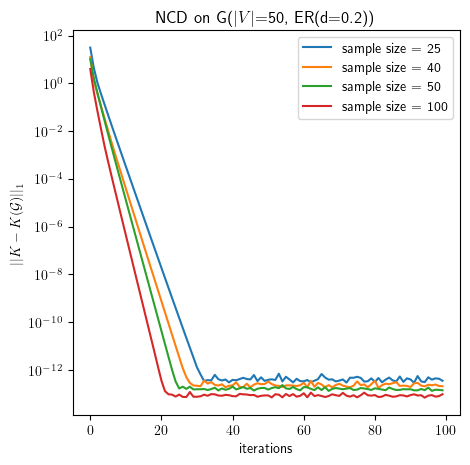

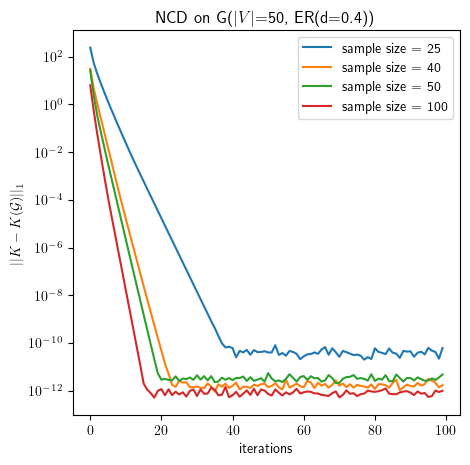

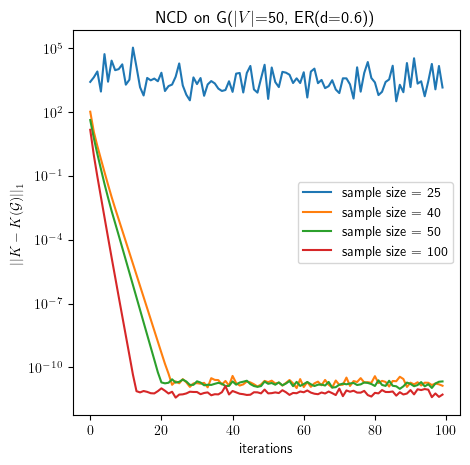

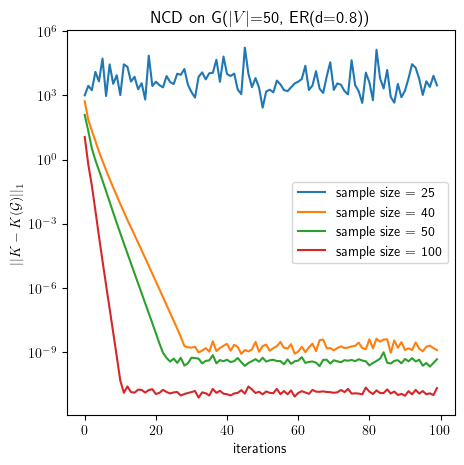

In [16]:
graphs = [
    RandomGraph(n=50, graph_structure='erdos_renyi', pd_selection='laplacian', d=0.2, seed=seed),
    RandomGraph(n=50, graph_structure='erdos_renyi', pd_selection='laplacian', d=0.4, seed=seed),
    RandomGraph(n=50, graph_structure='erdos_renyi', pd_selection='laplacian', d=0.6, seed=seed),
    RandomGraph(n=50, graph_structure='erdos_renyi', pd_selection='laplacian', d=0.8, seed=seed)
]
for G in graphs: 
    fig, ax = plt.subplots(figsize=(5,5))
    plt.rcParams['text.usetex'] = True
    iterations = 100
    for sample_size in [25, 40, 50, 100]:
        s = np.cov(G.sample(sample_size), rowvar=False, bias=False)
        sigma, errors = NCD_measured(s, G, iterations)
        ax.plot(np.arange(iterations), errors, label=f"sample size = {sample_size}")

    #ax.plot(np.arange(iterations), [1/G.n for _ in np.arange(iterations)], label=r"$d^{-1}$")
    ax.set_xlabel("iterations")
    ax.set_yscale('log')
    ax.set_ylabel(r"$||K-K(\mathcal{G})||_{1}$")
    ax.legend()
    ax.set_title(f"NCD on {G}")
#    plt.savefig(f"plots/ncd_on_{G.n}_{int(G.d*10)}.png")

In [17]:
def is_positive_definite_cholesky(matrix):
    try:
        np.linalg.cholesky(matrix)
        return True
    except np.linalg.LinAlgError:
        return False

In [18]:
def NCD_pd(data, G, n):
    # this value needs to be
    # positive definite in order
    # to guarantee convergences
    s = np.copy(data)
    for i in range(n):
        for u in range(s.shape[0]):
            b = G.neighbours[u,:]
            r = G.non_neighbours[u,:]
            if np.all(b == False):
                tmp_ru = np.array([[0]])
                tmp_ur = tmp_ru
            else:
                uu, ub, bu, ur, ru, br, rb, rr, bb = ncd_blocks(s,u,G)
                tmp_ru = np.matmul(rb, np.matmul(np.linalg.inv(bb),bu))
                tmp_ur = tmp_ru.T
            s[r,u] = tmp_ru
            s[u,r] = tmp_ur
        K = np.linalg.inv(s) 
        if is_positive_definite_cholesky(K * G.adj):
            return i
    return n

## Timing

NCD Took longer that 500 iterations to converge
NCD Took longer that 500 iterations to converge
NCD Took longer that 500 iterations to converge


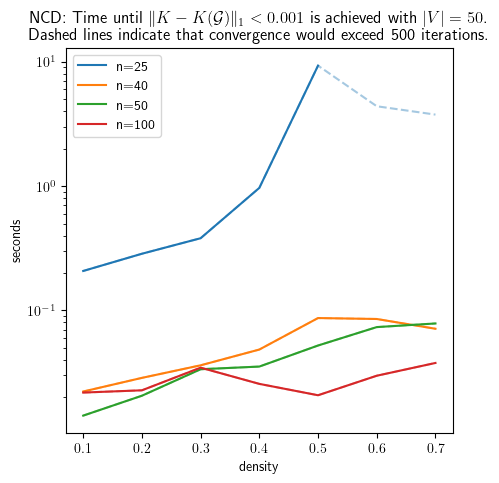

In [19]:
fig, ax = plt.subplots(figsize = (5,5))
plt.rcParams['text.usetex'] = True

n = 50
max_iter = 500
sample_sizes = [25, 40, 50, 100]
densities = np.array([0.1,0.2, 0.3,0.4, 0.5,0.6, 0.7])
epsilon = 0.001
for sample_size in sample_sizes:
    tmp = []
    tmp_i = []
    for d in densities:
        G = RandomGraph(n=n, graph_structure='erdos_renyi', pd_selection='laplacian', d=d, seed=seed)
        s = np.cov(G.sample(sample_size), rowvar=False, bias=False)
        start = time.time()
        _, i = NCD_epsilon(s, G, epsilon, max_iter)
        tmp.append(time.time() - start)
        tmp_i.append(i)
    tmp_i = np.array(tmp_i)
    # Find the index of the first True value
    mask = tmp_i == max_iter
    first_true_index = np.argmax(mask)
    # If there is at least one True value, update it to False
    if mask[first_true_index]:
        mask[first_true_index] = False
    line = ax.plot(densities, tmp, ls='--', alpha=0.4)[0]
    tmp = np.array(tmp)
    ax.plot(densities[~mask], tmp[~mask], label=f"n={sample_size}", color=line.get_color())
ax.set_xlabel("density")
ax.set_ylabel(f"seconds")
ax.set_yscale('log')
ax.set_title(
    r"NCD: Time until $\|K - K(\mathcal{G})\|_{1} < 0.001$ is achieved with $|V| = 50$."
    f"\nDashed lines indicate that convergence would exceed {max_iter} iterations."
)
ax.legend()
#plt.savefig("plots/ncd_time.png")
